In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import nltk

# Mount Google Drive to access datasets
drive.mount('/content/drive')

# Download NLTK data for POS tagging
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
# Load the datasets
true_df = pd.read_csv('/content/drive/My Drive/ISOT_Original/True.csv')
fake_df = pd.read_csv('/content/drive/My Drive/ISOT_Original/Fake.csv')

# Add labels: 1 for real news, 0 for fake news
true_df['label'] = 1
fake_df['label'] = 0

# Combine both sampled datasets
data = pd.concat([true_df, fake_df], ignore_index=True)

# Shuffle the dataset
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Check the split sizes
print(f"Training set size: {train_data.shape}")
print(f"Validation set size: {val_data.shape}")
print(f"Test set size: {test_data.shape}")


Training set size: (32326, 5)
Validation set size: (3592, 5)
Test set size: (8980, 5)


In [ ]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Removing special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Stop word removal
    tokens = [w for w in tokens if not w in stop_words]

    return " ".join(tokens)

# Apply preprocessing to the 'text' column of each dataset
train_data['text'] = train_data['text'].apply(preprocess_text)
val_data['text'] = val_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorizer for keyword extraction
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit on the training data and transform the datasets
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['text'])
X_val_tfidf = tfidf_vectorizer.transform(val_data['text'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['text'])


In [ ]:
import nltk

def extract_pos_features(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    nouns = sum(1 for word, tag in pos_tags if tag.startswith('NN'))
    verbs = sum(1 for word, tag in pos_tags if tag.startswith('VB'))
    adjectives = sum(1 for word, tag in pos_tags if tag.startswith('JJ'))
    return [nouns, verbs, adjectives]

# Apply POS extraction
train_data['pos_features'] = train_data['text'].apply(extract_pos_features)
val_data['pos_features'] = val_data['text'].apply(extract_pos_features)
test_data['pos_features'] = test_data['text'].apply(extract_pos_features)


In [ ]:
import spacy

# Load SpaCy model for NER extraction
nlp = spacy.load('en_core_web_sm')

def extract_ner_count(text):
    doc = nlp(text)
    return len(doc.ents)

# Apply NER extraction
train_data['ner_count'] = train_data['text'].apply(extract_ner_count)
val_data['ner_count'] = val_data['text'].apply(extract_ner_count)
test_data['ner_count'] = test_data['text'].apply(extract_ner_count)


In [ ]:
from textblob import TextBlob

def extract_sentiment(text):
    sentiment = TextBlob(text).sentiment.polarity
    return sentiment

# Apply Sentiment Analysis
train_data['sentiment'] = train_data['text'].apply(extract_sentiment)
val_data['sentiment'] = val_data['text'].apply(extract_sentiment)
test_data['sentiment'] = test_data['text'].apply(extract_sentiment)


In [ ]:
# Combine all features (TF-IDF, POS, NER, Sentiment) for training
X_train_combined = np.hstack([
    X_train_tfidf.toarray(),
    np.array(train_data['pos_features'].tolist()),
    np.array(train_data['ner_count']).reshape(-1, 1),
    np.array(train_data['sentiment']).reshape(-1, 1)
])

X_val_combined = np.hstack([
    X_val_tfidf.toarray(),
    np.array(val_data['pos_features'].tolist()),
    np.array(val_data['ner_count']).reshape(-1, 1),
    np.array(val_data['sentiment']).reshape(-1, 1)
])

X_test_combined = np.hstack([
    X_test_tfidf.toarray(),
    np.array(test_data['pos_features'].tolist()),
    np.array(test_data['ner_count']).reshape(-1, 1),
    np.array(test_data['sentiment']).reshape(-1, 1)
])

# Labels
y_train = train_data['label']
y_val = val_data['label']
y_test = test_data['label']


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_combined, y_train)

# Validation prediction and performance
y_val_pred = model.predict(X_val_combined)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Test prediction and performance
y_test_pred = model.predict(X_test_combined)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1853
           1       0.98      0.98      0.98      1739

    accuracy                           0.98      3592
   macro avg       0.98      0.98      0.98      3592
weighted avg       0.98      0.98      0.98      3592

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4669
           1       0.98      0.99      0.99      4311

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



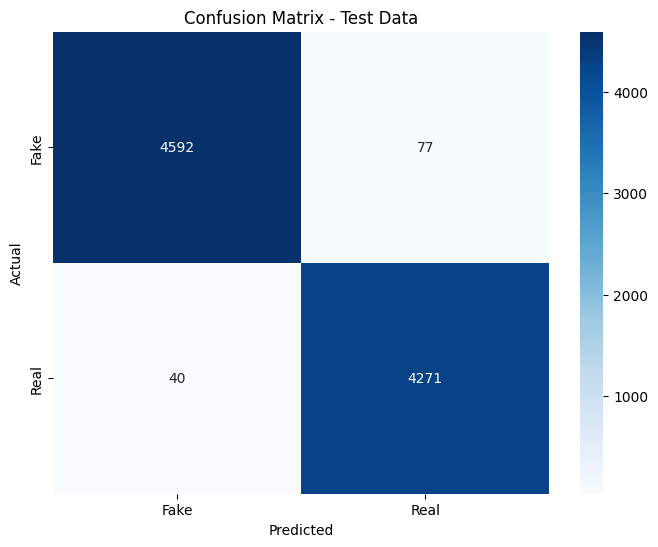

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Data')
plt.show()

In [ ]:
import joblib

# Save the trained model and vectorizer
joblib.dump(model, '/content/drive/My Drive/fake_news_model.pkl')
joblib.dump(tfidf_vectorizer, '/content/drive/My Drive/tfidf_vectorizer.pkl')

# Save the extracted features (if needed)
train_data.to_csv('/content/drive/My Drive/train_data_with_features.csv', index=False)
val_data.to_csv('/content/drive/My Drive/val_data_with_features.csv', index=False)
test_data.to_csv('/content/drive/My Drive/test_data_with_features.csv', index=False)


In [ ]:
# Load saved model and vectorizer
model = joblib.load('/content/drive/My Drive/fake_news_model.pkl')
tfidf_vectorizer = joblib.load('/content/drive/My Drive/tfidf_vectorizer.pkl')

# Sample input for prediction
sample_input = ["Breaking news: Scientists find cure for cancer."]

# Preprocess the input
sample_tfidf = tfidf_vectorizer.transform(sample_input)

# For POS, NER, and Sentiment features
sample_pos = extract_pos_features(sample_input[0])
sample_ner = extract_ner_count(sample_input[0])
sample_sentiment = extract_sentiment(sample_input[0])

# Combine all features for the sample input
sample_combined = np.hstack([
    sample_tfidf.toarray(),
    np.array([sample_pos]),
    np.array([[sample_ner]]),
    np.array([[sample_sentiment]])
])

# Predict using the model
prediction = model.predict(sample_combined)
print("Prediction:", "Real News" if prediction[0] == 1 else "Fake News")


Prediction: Fake News


In [ ]:
print(train_data[['pos_features', 'ner_count', 'sentiment']].head())
print(val_data[['pos_features', 'ner_count', 'sentiment']].head())
print(test_data[['pos_features', 'ner_count', 'sentiment']].head())

         pos_features  ner_count  sentiment
26654     [29, 11, 6]          7   0.158636
35552  [392, 167, 92]        145  -0.004779
20522   [199, 88, 50]         66   0.063891
28874   [102, 38, 24]         37   0.130974
3406   [355, 214, 78]        104   0.119159
         pos_features  ner_count  sentiment
4126    [108, 46, 27]         35   0.107184
5110     [79, 50, 17]         26   0.014006
16867     [30, 28, 8]         15  -0.016880
12221  [229, 107, 46]         83   0.015541
27688  [226, 125, 38]         35   0.020734
        pos_features  ner_count  sentiment
22216    [44, 16, 7]         13  -0.085937
27917   [99, 86, 26]         22   0.110351
25007   [49, 34, 17]         11   0.125764
1377     [31, 12, 5]         13   0.125000
32476  [107, 74, 30]         28   0.066049


In [ ]:
import numpy as np
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import spacy
from textblob import TextBlob

model = joblib.load('/content/drive/My Drive/fake_news_model.pkl')
tfidf_vectorizer = joblib.load('/content/drive/My Drive/tfidf_vectorizer.pkl')



def extract_pos_features(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    nouns = sum(1 for word, tag in pos_tags if tag.startswith('NN'))
    verbs = sum(1 for word, tag in pos_tags if tag.startswith('VB'))
    adjectives = sum(1 for word, tag in pos_tags if tag.startswith('JJ'))
    return [nouns, verbs, adjectives]

def extract_ner_count(text):
    doc = nlp(text)
    return len(doc.ents)

def extract_sentiment(text):
    sentiment = TextBlob(text).sentiment.polarity
    return sentiment

def predict_news(input_texts):
  predictions = []
  for text in input_texts:
    sample_tfidf = tfidf_vectorizer.transform([text])
    sample_pos = extract_pos_features(text)
    sample_ner = extract_ner_count(text)
    sample_sentiment = extract_sentiment(text)
    sample_combined = np.hstack([
        sample_tfidf.toarray(),
        np.array([sample_pos]),
        np.array([[sample_ner]]),
        np.array([[sample_sentiment]])
    ])
    prediction = model.predict(sample_combined)
    predictions.append("Real News" if prediction[0] == 1 else "Fake News")
  return predictions

# Example usage with 10 inputs
sample_inputs = [
    "Breaking news: Scientists find cure for cancer.",
    "The president announced a new policy today.",
    "Aliens have landed in New York City!",
    "Stock market crashes after unexpected economic downturn.",
    "Local bakery wins national award for its delicious pastries.",
    "Celebrity couple announces their engagement.",
    "Mysterious object spotted in the sky over Area 51.",
    "New study reveals surprising findings about climate change.",
    "World leaders gather for international summit on peace.",
    "Tech giant releases its latest innovative product."
]

predictions = predict_news(sample_inputs)
for i, prediction in enumerate(predictions):
  print(f"Input {i+1}: {sample_inputs[i]} \nPrediction: {prediction}\n")

Input 1: Breaking news: Scientists find cure for cancer. 
Prediction: Fake News

Input 2: The president announced a new policy today. 
Prediction: Fake News

Input 3: Aliens have landed in New York City! 
Prediction: Fake News

Input 4: Stock market crashes after unexpected economic downturn. 
Prediction: Fake News

Input 5: Local bakery wins national award for its delicious pastries. 
Prediction: Fake News

Input 6: Celebrity couple announces their engagement. 
Prediction: Fake News

Input 7: Mysterious object spotted in the sky over Area 51. 
Prediction: Fake News

Input 8: New study reveals surprising findings about climate change. 
Prediction: Fake News

Input 9: World leaders gather for international summit on peace. 
Prediction: Fake News

Input 10: Tech giant releases its latest innovative product. 
Prediction: Fake News



In [ ]:
true_news_samples = true_df['text'].sample(n=10).tolist()

predictions = predict_news(true_news_samples)
for i, prediction in enumerate(predictions):
  print(f"Input {i+1}: {true_news_samples[i][:100]}... \nPrediction: {prediction}\n")


fake_news_samples = fake_df['text'].sample(n=10).tolist()

predictions = predict_news(fake_news_samples)
for i, prediction in enumerate(predictions):
    print(f"Input {i+1}: {fake_news_samples[i][:100]}... \nPrediction: {prediction}\n")

Input 1: NEW YORK (Reuters) - Sweeping U.S. tax legislation appears to be on the verge of approval, lifting t... 
Prediction: Real News

Input 2: SEATTLE (Reuters) - Republican U.S. President Donald Trump’s efforts to renegotiate or scrap longsta... 
Prediction: Real News

Input 3: WARSAW (Reuters) - Changes to Poland s electoral code approved by parliament on Thursday threaten th... 
Prediction: Real News

Input 4: MOGADISHU (Reuters) - The United States military has carried out an air strike in Somalia against al... 
Prediction: Real News

Input 5: BERLIN (Reuters) - U.S. President Barack Obama and European leaders on Friday underscored the import... 
Prediction: Real News

Input 6: WASHINGTON (Reuters) - U.S. Senate Republican leader Mitch McConnell on Tuesday announced a delay in... 
Prediction: Real News

Input 7: WELLINGTON (Reuters) - The final opinion poll before New Zealand s election on Saturday showed the r... 
Prediction: Real News

Input 8: BERLIN (Reuters) - Chancellor An

In [ ]:
import joblib
import nltk
import numpy as np
import spacy
from textblob import TextBlob

# Download necessary NLTK data (if not already downloaded)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

# Load the saved model and vectorizer
model = joblib.load('/content/drive/My Drive/fake_news_model.pkl')
tfidf_vectorizer = joblib.load('/content/drive/My Drive/tfidf_vectorizer.pkl')

def extract_pos_features(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    nouns = sum(1 for word, tag in pos_tags if tag.startswith('NN'))
    verbs = sum(1 for word, tag in pos_tags if tag.startswith('VB'))
    adjectives = sum(1 for word, tag in pos_tags if tag.startswith('JJ'))
    return [nouns, verbs, adjectives]

def extract_ner_count(text):
    doc = nlp(text)
    return len(doc.ents)

def extract_sentiment(text):
    sentiment = TextBlob(text).sentiment.polarity
    return sentiment

def predict_news(input_texts):
  predictions = []
  for text in input_texts:
    sample_tfidf = tfidf_vectorizer.transform([text])
    sample_pos = extract_pos_features(text)
    sample_ner = extract_ner_count(text)
    sample_sentiment = extract_sentiment(text)
    sample_combined = np.hstack([
        sample_tfidf.toarray(),
        np.array([sample_pos]),
        np.array([[sample_ner]]),
        np.array([[sample_sentiment]])
    ])
    prediction = model.predict(sample_combined)
    predictions.append("Real News" if prediction[0] == 1 else "Fake News")
  return predictions

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
import random
import pandas as pd # Import pandas

# Load the datasets (This needs to be done in this cell)
true_df = pd.read_csv('/content/drive/My Drive/ISOT/True.csv')
fake_df = pd.read_csv('/content/drive/My Drive/ISOT/Fake.csv')

# Randomly select 5 true and 5 fake news articles
true_indices = random.sample(range(len(true_df)), 5)
fake_indices = random.sample(range(len(fake_df)), 5)

true_news_samples = [true_df['text'].iloc[i] for i in true_indices]
fake_news_samples = [fake_df['text'].iloc[i] for i in fake_indices]

# Combine true and fake samples
combined_samples = true_news_samples + fake_news_samples
true_labels = [1] * 5 + [0] * 5 # Corresponding true labels

predictions = predict_news(combined_samples)

# Evaluate predictions
correct_predictions = 0
for i in range(10):
    predicted_label = 1 if predictions[i] == "Real News" else 0
    if predicted_label == true_labels[i]:
        correct_predictions += 1
    print(f"Input {i + 1}: {combined_samples[i][:100]}... \nPrediction: {predictions[i]}, Actual: {'Real News' if true_labels[i] == 1 else 'Fake News'}\n")

print(f"Accuracy: {correct_predictions / 10}")

Input 1: PHILADELPHIA (Reuters) - Democrat Hillary Clinton on Monday accused Republican Donald Trump of aidin... 
Prediction: Real News, Actual: Real News

Input 2: WASHINGTON (Reuters) - The top Republican in the U.S. Congress dimmed hopes that lawmakers might end... 
Prediction: Real News, Actual: Real News

Input 3: BOSTON (Reuters) - Massachusetts Governor Charlie Baker proposed a bill on Tuesday to allow police a... 
Prediction: Real News, Actual: Real News

Input 4: (Reuters) - Democratic presidential candidate Hillary Clinton has pledged to raise taxes on the weal... 
Prediction: Real News, Actual: Real News

Input 5: (Reuters) - U.S. President Donald Trump does not plan to invoke executive privilege as a way to bloc... 
Prediction: Real News, Actual: Real News

Input 6: Democrat Delegate Mary Bayer was caught on undercover video explaining how Hillary will deceptively ... 
Prediction: Fake News, Actual: Fake News

Input 7: No Obama won t run again, but he ll use every dirty pol

In [ ]:
import random

# Randomly select 5 true and 5 fake news articles
true_indices = random.sample(range(len(true_df)), 5)
fake_indices = random.sample(range(len(fake_df)), 5)

true_news_samples = [true_df['text'].iloc[i] for i in true_indices]
fake_news_samples = [fake_df['text'].iloc[i] for i in fake_indices]

# Combine true and fake samples
combined_samples = true_news_samples + fake_news_samples
true_labels = [1] * 5 + [0] * 5 # Corresponding true labels

predictions = predict_news(combined_samples)

# Evaluate predictions
correct_predictions = 0
for i in range(10):
    predicted_label = 1 if predictions[i] == "Real News" else 0
    if predicted_label == true_labels[i]:
        correct_predictions += 1
    print(f"Input {i + 1}: {combined_samples[i][:100]}... \nPrediction: {predictions[i]}, Actual: {'Real News' if true_labels[i] == 1 else 'Fake News'}\n")

print(f"Accuracy: {correct_predictions / 10}")

Input 1: MOSCOW (Reuters) - Russia does not believe that U.S. President Donald Trump’s new strategy on Afghan... 
Prediction: Real News, Actual: Real News

Input 2: WASHINGTON (Reuters) - U.S. President Donald Trump supports the goal of peace between Israel and the... 
Prediction: Real News, Actual: Real News

Input 3: WASHINGTON (Reuters) - President Barack Obama commuted the prison sentences of 330 federal inmates, ... 
Prediction: Real News, Actual: Real News

Input 4: WASHINGTON (Reuters) - U.S. Secretary of State Rex Tillerson said on Tuesday a policy of engagement ... 
Prediction: Real News, Actual: Real News

Input 5: DETROIT (Reuters) - When U.S. President Donald Trump announced a review last week of tough Obama-era... 
Prediction: Real News, Actual: Real News

Input 6: This is rich! Left-leaning Washington Post does a hit job on Hillary: JUST THE FACTS ARE PROVIDED EX... 
Prediction: Fake News, Actual: Fake News

Input 7: Will anyone on the left even care? If she were in priso

In [ ]:

# Randomly select 5 true and 5 fake news articles
true_indices = random.sample(range(len(true_df)), 5)
fake_indices = random.sample(range(len(fake_df)), 5)

true_news_samples = [true_df['text'].iloc[i] for i in true_indices]
fake_news_samples = [fake_df['text'].iloc[i] for i in fake_indices]

# Combine true and fake samples
combined_samples = true_news_samples + fake_news_samples
true_labels = [1] * 5 + [0] * 5  # Corresponding true labels

predictions = predict_news(combined_samples)

# Evaluate predictions
correct_predictions = 0
for i in range(10):
    predicted_label = 1 if predictions[i] == "Real News" else 0
    if predicted_label == true_labels[i]:
        correct_predictions += 1
    print(
        f"Input {i + 1}: {combined_samples[i][:100]}... \nPrediction: {predictions[i]}, Actual:"
        f" {'Real News' if true_labels[i] == 1 else 'Fake News'}\n"
    )

print(f"Accuracy: {correct_predictions / 10}")

Input 1: BEIJING/TAIPEI (Reuters) - China warned on Wednesday that any interference with or damage to the “on... 
Prediction: Real News, Actual: Real News

Input 2: (Reuters) - U.S. President-elect Donald Trump held meetings in New York on Monday as he worked to fi... 
Prediction: Real News, Actual: Real News

Input 3: WASHINGTON (Reuters) - President Donald J. Trump nominated Brian Quintenz, a former fund manager, co... 
Prediction: Real News, Actual: Real News

Input 4: WASHINGTON (Reuters) - The leaders of a House of Representatives probe of possible Russian meddling ... 
Prediction: Real News, Actual: Real News

Input 5: WASHINGTON (Reuters) - The U.S. Senate voted on Thursday to confirm retired neurosurgeon Ben Carson ... 
Prediction: Real News, Actual: Real News

Input 6: War veteran Johnny  Joey  Jones praised President Trump for dropping the  mother of all bombs  on IS... 
Prediction: Fake News, Actual: Fake News

Input 7: If you watch CNBC at all you know John Harwood is a HUG